In [ ]:
import torch
from transformers import CLIPVisionModelWithProjection,CLIPImageProcessor
from diffusers.utils import load_image
import os,sys

from kolors.pipelines.pipeline_stable_diffusion_xl_chatglm_256_ipadapter import StableDiffusionXLPipeline
from kolors.models.modeling_chatglm import ChatGLMModel
from kolors.models.tokenization_chatglm import ChatGLMTokenizer

# from diffusers import UNet2DConditionModel, AutoencoderKL
from diffusers import  AutoencoderKL
from kolors.models.unet_2d_condition import UNet2DConditionModel

from diffusers import EulerDiscreteScheduler
from PIL import Image

In [5]:
# Model Base Path
MBP = "/data/model/weights/"
# load models
text_encoder = ChatGLMModel.from_pretrained(f"{MBP}/Kolors/text_encoder", torch_dtype=torch.float16).half()
tokenizer = ChatGLMTokenizer.from_pretrained(f'{MBP}/Kolors/text_encoder')
vae = AutoencoderKL.from_pretrained(f"{MBP}/Kolors/vae", revision=None).half()
scheduler = EulerDiscreteScheduler.from_pretrained(f"{MBP}/Kolors/scheduler")
unet = UNet2DConditionModel.from_pretrained(f"{MBP}/Kolors/unet", revision=None).half()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(f'{MBP}/Kolors-IP-Adapter-Plus/image_encoder',
                                                              ignore_mismatched_sizes=True).to(dtype=torch.float16)
ip_img_size = 336
clip_image_processor = CLIPImageProcessor(size=ip_img_size, crop_size=ip_img_size )

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
# sd pipeline
pipe = StableDiffusionXLPipeline(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            image_encoder=image_encoder,  # !!!
            feature_extractor=clip_image_processor,  # !!!
            force_zeros_for_empty_prompt=False)
pipe = pipe.to("cuda")
pipe.enable_model_cpu_offload()
if hasattr(pipe.unet, 'encoder_hid_proj'):
    pipe.unet.text_encoder_hid_proj = pipe.unet.encoder_hid_proj
pipe.load_ip_adapter(f'{MBP}/Kolors-IP-Adapter-Plus', subfolder="", weight_name=["ip_adapter_plus_general.bin"])

In [7]:
# generate
def ipa(img, prompt, height=1024, width=1024,
        num_inference_steps=50, guidance_scale=5.0, num_images_per_prompt=1,
        generator= torch.Generator(pipe.device).manual_seed(66)):
    ip_adapter_img = Image.open(img)
    pipe.set_ip_adapter_scale([0.5])
    return pipe(prompt=prompt,
                ip_adapter_image=[ip_adapter_img],
                height=height, width=width, num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale, num_images_per_prompt=num_images_per_prompt, generator=generator)


  0%|          | 0/50 [00:00<?, ?it/s]

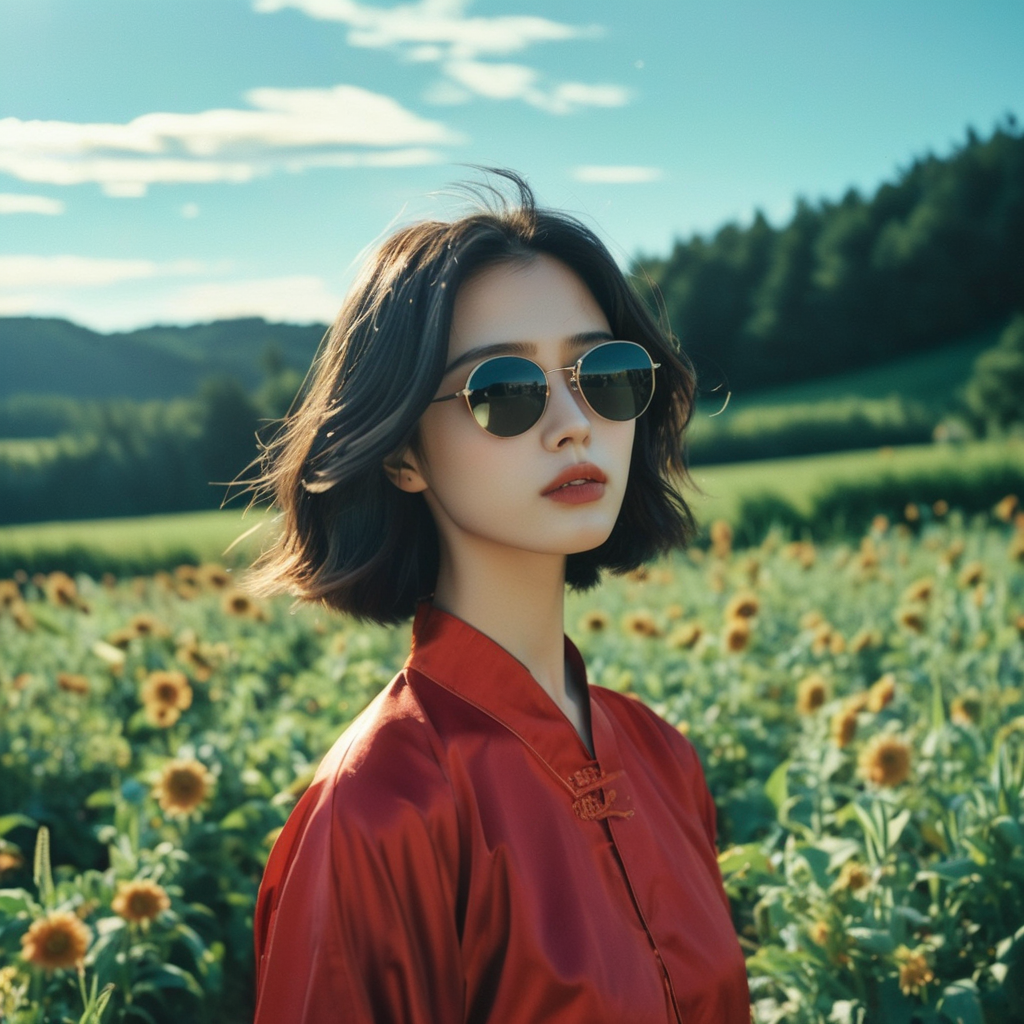

In [13]:
# testing
ipa("/root/workspace/Kolors/ipadapter/asset/test_ip.jpg", prompt="女子看下天空，眺望远方，中国传统，红色嫁衣，太阳镜，").images[0].show()

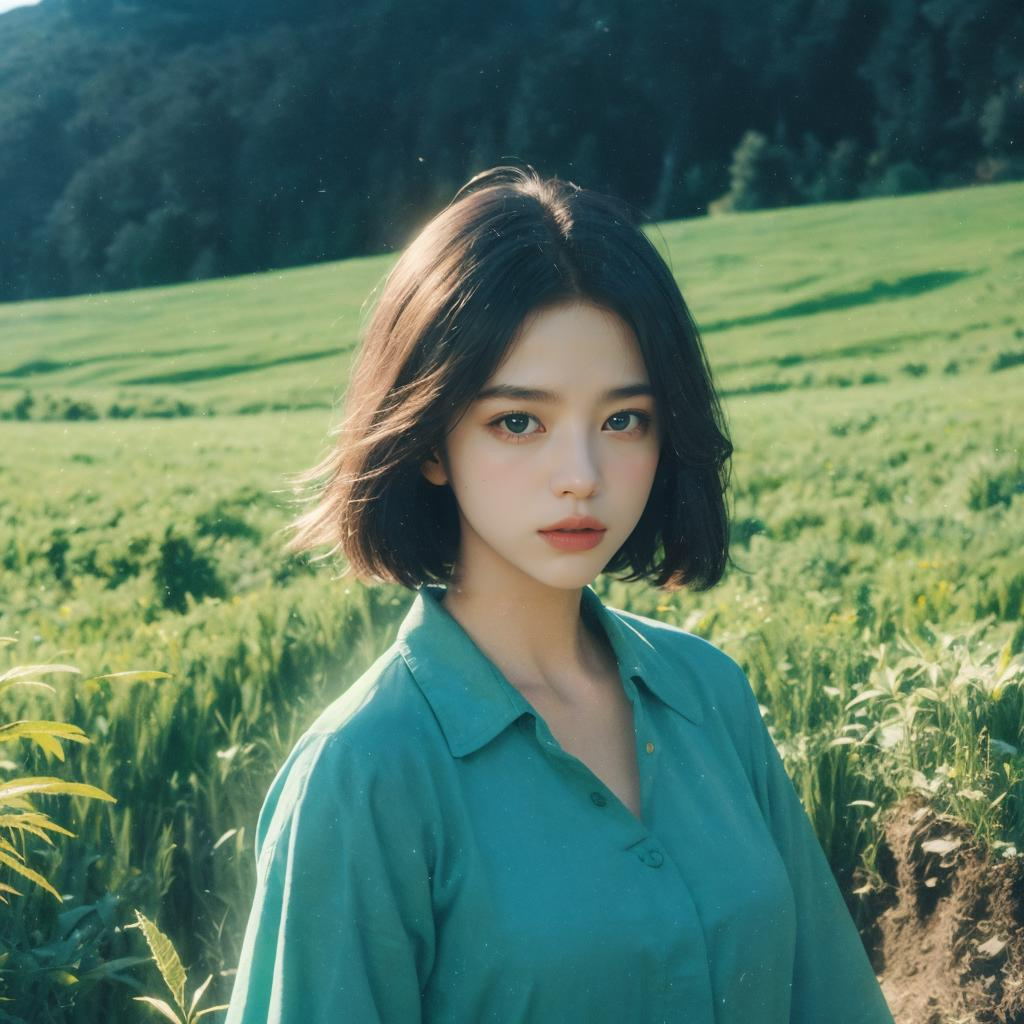

In [14]:
Image.open("/root/workspace/Kolors/ipadapter/asset/test_ip.jpg").show()